In [2]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# modflow utility 
import flopy
import flopy.utils.binaryfile as bf


In [3]:

## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = os.path.dirname(git_dir)
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\andrewc\Documents\GitHub\CosumnesRiverRecharge C:\Users\andrewc/Box/research_cosumnes/GWFlowModel


In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/'
model_ws = loadpth+'flood_depth_analysis'

In [7]:
nrow = 100
ncol = 230
nlay = 3
delr = 200
delc = 200

# # m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
# #                           version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws=model_ws)
# #lenuni = 1 is in ft, lenuni = 2 is in meters
# # itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
# dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
#                                nlay=nlay, delr=delr, delc=delc,
#                                model=m, lenuni = 2, itmuni = 4,
#                                xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
#                               nper = nper, perlen=perlen, nstp=nstp, steady = steady,
#                               start_datetime = strt_date)


In [8]:
# burn river shapefile into the 10 meter dem and then read it out to find the cells where it is
from flopy.utils import Raster
# Full size dem of northern sac valley
raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"

# rio10_utm = Raster.load(raster_name)
rio10_utm = rasterio.open(raster_name)
dem_10m = rio10_utm.read((1,))

In [9]:
# load sacramento river, creeks
rivers = gpd.read_file(gwfm_dir+'/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiLineString'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [12]:
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')


C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [13]:
cr = gpd.overlay(rivers.loc[rivers.GNIS_Name=='Cosumnes River'].to_crs('epsg:32610'), m_domain)

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207

In [14]:
from shapely.geometry import MultiLineString, LineString, Point, shape, mapping
from shapely.ops import linemerge
import fiona

cr_line = MultiLineString(cr.geometry.values)

### Parallel XS

In [15]:


geom = shape(cr_line)

# # length of the LineString
length = int(geom.length)
sfr_sp = gpd.GeoDataFrame(pd.DataFrame(np.zeros((length,1)),columns=['id']))
sfr_sp['geometry'] = shapely.geometry.Point(0,0)
# enumerate keeps track of the count in addition to the object being iterated on
for i, distance in enumerate(range(0, length, 1)):
    point = geom.interpolate(distance)
    sfr_sp.loc[i,'geometry'] = point
    sfr_sp.loc[i,'id'] = i

In [16]:
sfr_sp['Easting'] = sfr_sp.geometry.x.values
sfr_sp['Northing'] = sfr_sp.geometry.y.values

point = sfr_sp.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    sfr_sp['z_ft'] = [sample[0] for sample in src.sample(point)]
    
sfr_sp['z_m'] = sfr_sp.loc[:,'z_ft']*0.3048


Find XS every 1000 meters avoids too much overlap in XS, but after calculating depth there is some discontinuity, so more might be better

In [17]:
geom = linemerge(cr.geometry.values)
# geom = geom.simplify(10)
# how often to interpolate a point, 200 m matches model grid
dline = 1000
# # length of the LineString
length = int(geom.length)
# max width needed is 3200 m
xs_width = 3200

num_xs = np.floor(length/dline).astype(int)
transects = pd.DataFrame(np.zeros((num_xs,1)), columns = ['line'])
transects['geometry'] = LineString([(0,0),(0,1)]) #initiate LineString geometry column


for i, distance in enumerate(range(0, int(length), dline)):
    short_line = LineString([geom.interpolate(distance),geom.interpolate(distance+dline)])
    geom_left = short_line.parallel_offset(xs_width/2,'left', resolution = 32, join_style = 2)
    geom_right = short_line.parallel_offset(xs_width/2,'right', resolution = 32, join_style = 2)
    perp_line = LineString([geom_left.boundary[1], geom_right.boundary[0]])
    transects.loc[i,'geometry'] = perp_line

<AxesSubplot:>

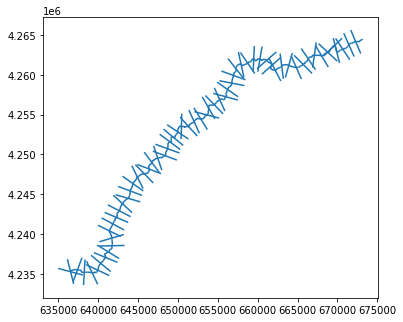

In [18]:
transg = gpd.GeoDataFrame(transects)
transg = transg.drop_duplicates('geometry')
transg['line'] = np.arange(0,len(transg))
# check cross section lines are paralle
fig,ax=plt.subplots(figsize=(6,6))
transg.plot(ax=ax)
cr.plot(ax=ax)


In [19]:
# # how often to interpolate a point in a XS
dline = 10

xs_all = gpd.GeoDataFrame(pd.DataFrame(columns=['xs_num','dist_from_right_m','geometry']))


for j in np.arange(0,len(transg)):
    xs = gpd.GeoDataFrame(pd.DataFrame(np.zeros((int(xs_width/dline),2)), columns=['xs_num','dist_from_right_m']))
    xs['geometry'] = Point([(0,0)])
    xs['xs_num'] = j
    
    # pick one geometry at a time
    geom = transg.iloc[j].geometry

    # # # length of the LineString
    length = int(geom.length)
    # create discrete points for each lien
    for i, distance in enumerate(range(0, int(length), dline)):
        point = geom.interpolate(distance)
        xs.loc[i,'geometry'] = point
        xs.loc[i,'dist_from_right_m'] = i
    # append individual cross section to all dataframe
    xs_all = xs_all.append(xs)

In [20]:
xs_all.crs='epsg:32610'
xs_all['Easting'] = xs_all.geometry.x
xs_all['Northing'] = xs_all.geometry.y
point = xs_all.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    xs_all['z_ft'] = [sample[0] for sample in src.sample(point)]

xs_all['z_m'] = xs_all.loc[:,'z_ft']*0.3048
# convert distance from right from 1/10 of meters because points were every 10 meters
# the distance was set with the index but really it should be 3200 meters not just 320 meters
xs_all.dist_from_right_m *= 10


## XS Cleaning
There isn't going to be a clear way to distinguish the levees and the XS shows bumpiness. The best solution will be to assume that levee setback will involve a cut and fill approach such that the ground surface elevation after setback is the mean of the elevation from before, but then this won't allow variable flooding based on elevation...

It will take looking at the XS in different regions.
It might be doable to fill in the channel as Sierra suggested which would raise the river above the levee and then install new "levee walls" at the desired distance. Filling in just the channel requires: 1. Going to the center line 2. go out some distance to account for channel width 3. set those values as a fraction of the levee height to insure more overbank flooding

In [21]:
# remove any NA values picked up from DEM raster
xs_all.loc[xs_all['z_ft'] == xs_all.z_ft.min(), ['z_ft','z_m']] = np.nan
xs_all.index = np.arange(0,len(xs_all))
xs_all.drop(['geometry'],axis=1).to_csv('XS_point_elevations.csv')

# convert to dataframe for easier plotting
xs_all_df = pd.DataFrame(xs_all)
# pivot based on XS number and save only elevation in z_m
xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')
xs_all_df.to_csv('Elevation_by_XS_number_meters.csv')

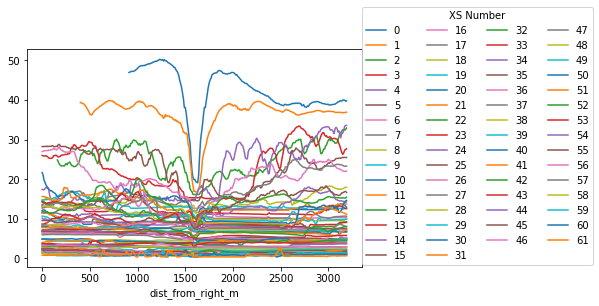

In [22]:

xs_all_df.plot()
plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


The process will be too complicated too directly edit the raster, so individual cross-sections will be edited by applying a rolling mean in the floodplain in the 200-400 m around the main channel to "flatten" any levee like structure. Then new 'levee walls' will be placed at the desired setback distance.


It doesn't look like I will see much floodplain inundation, but I won't know until I estimate depth. Start by assuming 2000 cfs is 2-3 year and 10,000 cfs is the 20 yr??

In [23]:
# 40 observations is equal to 400 meters
xs_levee_smooth = xs_all_df.copy()
roll_window = 40
xs_roll_mean = xs_all_df.rolling(roll_window, center=True).mean()
channel_middle = int(len(xs_all_df)/2)*10
channel_bool = (xs_all_df.index >= channel_middle - (roll_window*10/2))& (xs_all_df.index <= channel_middle + (roll_window*10/2))
xs_levee_smooth.loc[channel_bool,:] = xs_roll_mean.loc[channel_bool,:]


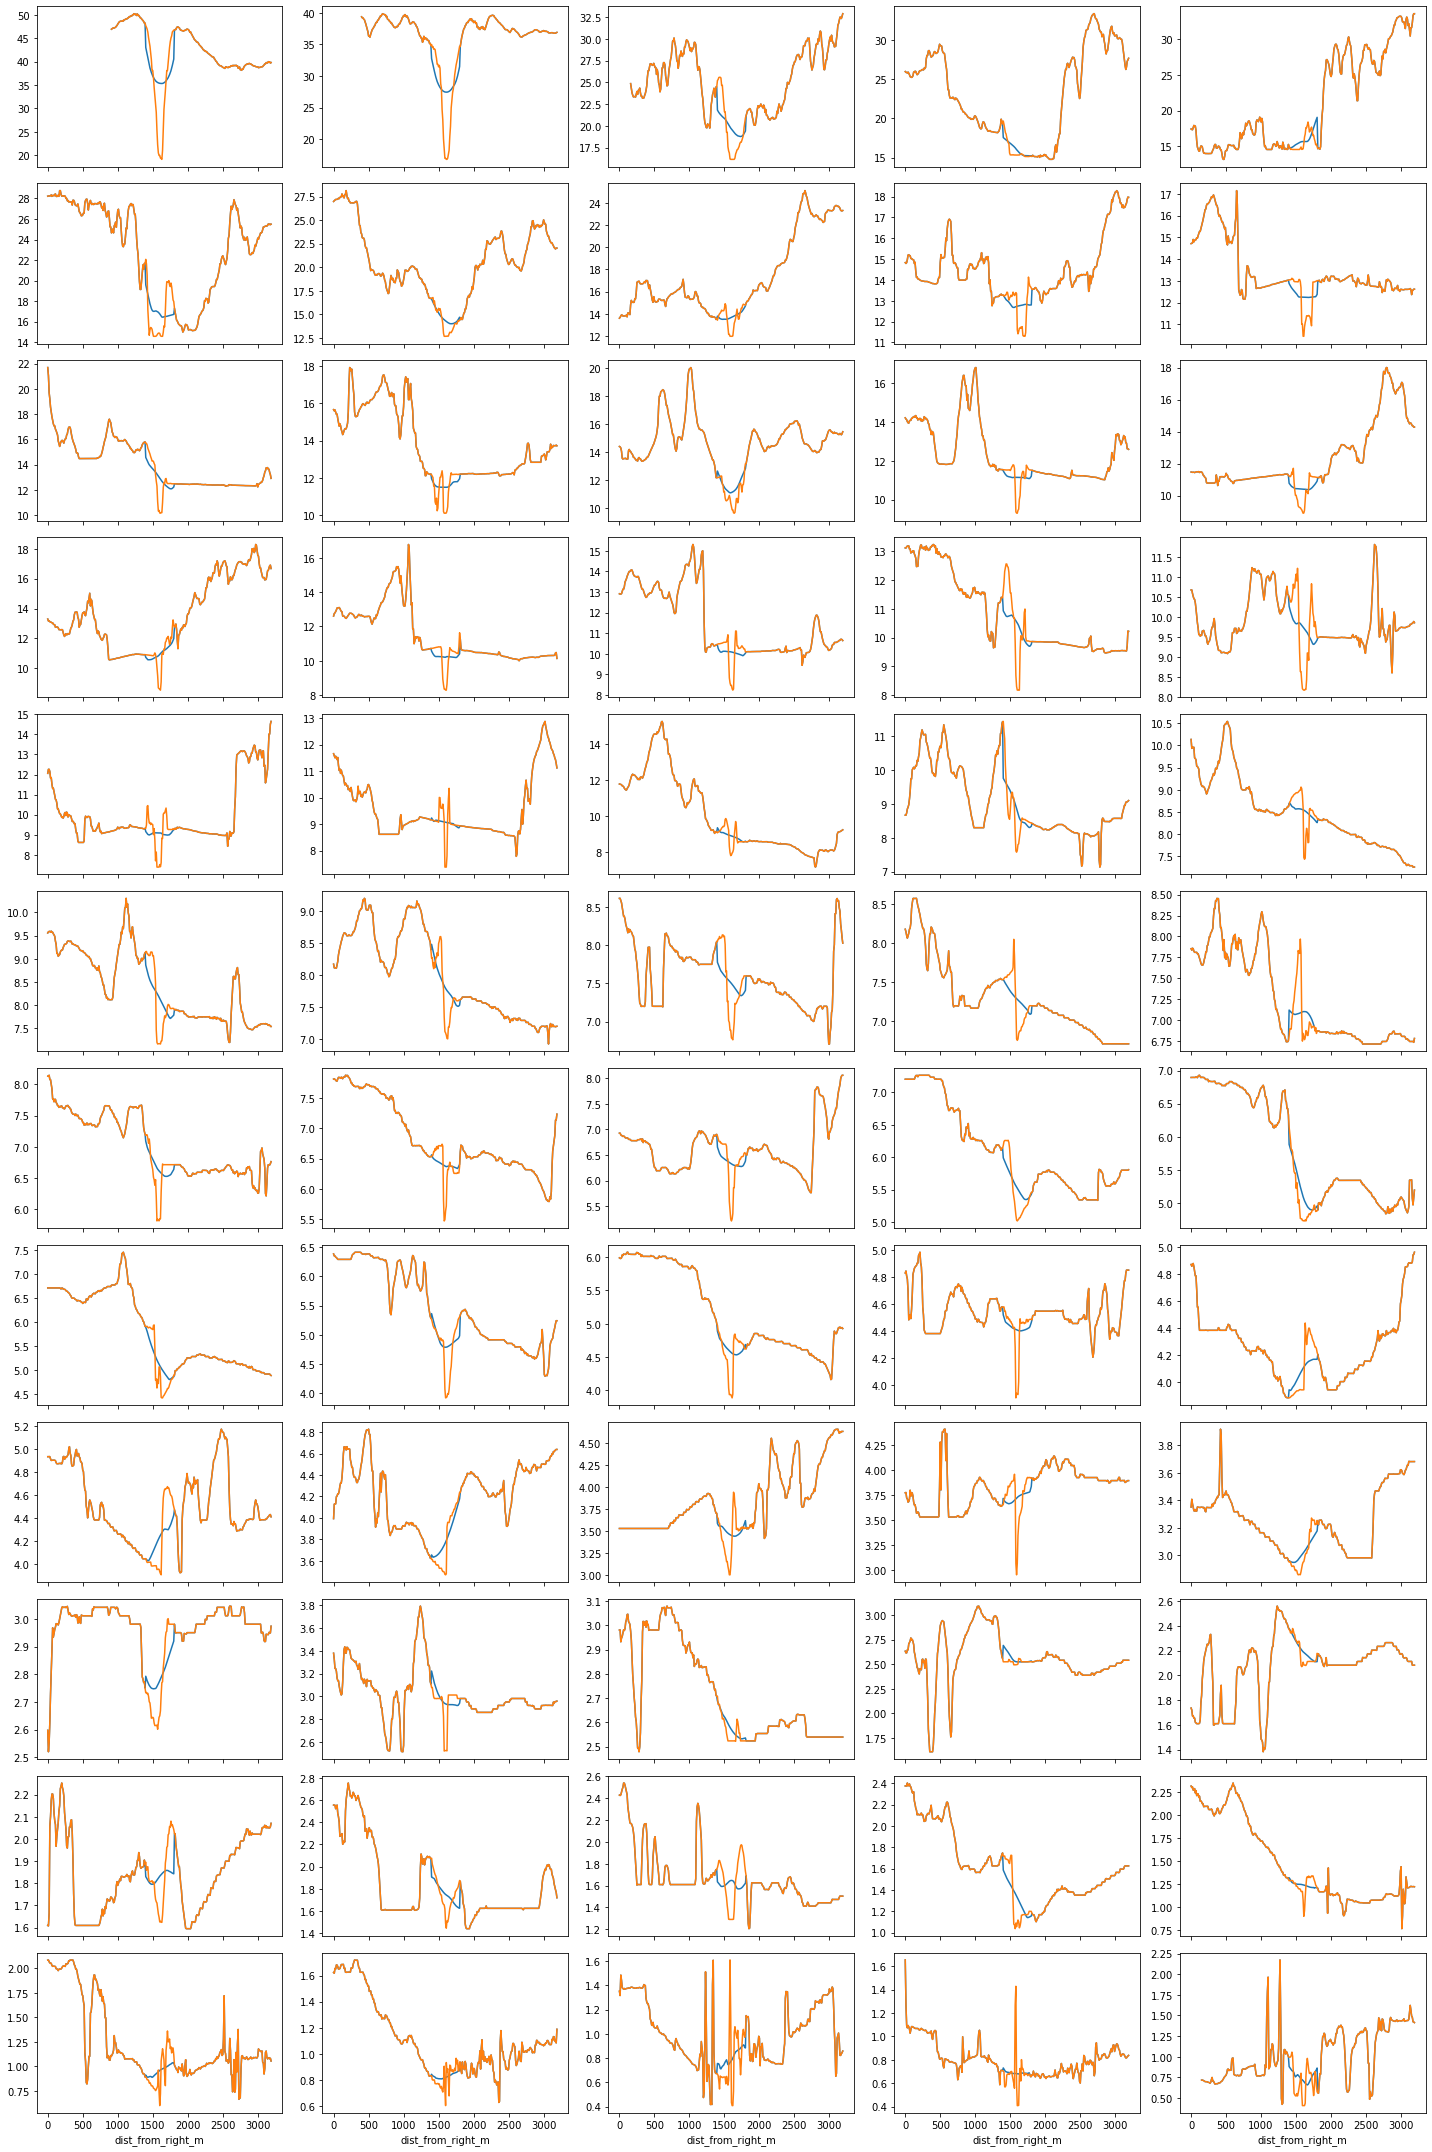

In [24]:
nx,ny = 12,5
fig,ax = plt.subplots(nx,ny, figsize=(20,30),sharex=True)
n=0
for i in np.arange(0,nx):
    for j in np.arange(0,ny):
        xs_levee_smooth.iloc[:,n].plot(ax=ax[i,j])
        xs_all_df.iloc[:,n].plot(ax=ax[i,j])
        n+=1
fig.tight_layout()

In [25]:
xs_mean_vals = xs_all_df.mean()
ct, xs_hist_vals = np.histogram(xs_mean_vals, bins= 6)
n=1
xs_grp = xs_all_df.loc[:,(xs_mean_vals <= xs_hist_vals[n]).values&(xs_mean_vals >= xs_hist_vals[n-1]).values]
xs_grp = xs_levee_smooth.loc[:,(xs_mean_vals <= xs_hist_vals[n]).values&(xs_mean_vals >= xs_hist_vals[n-1]).values]

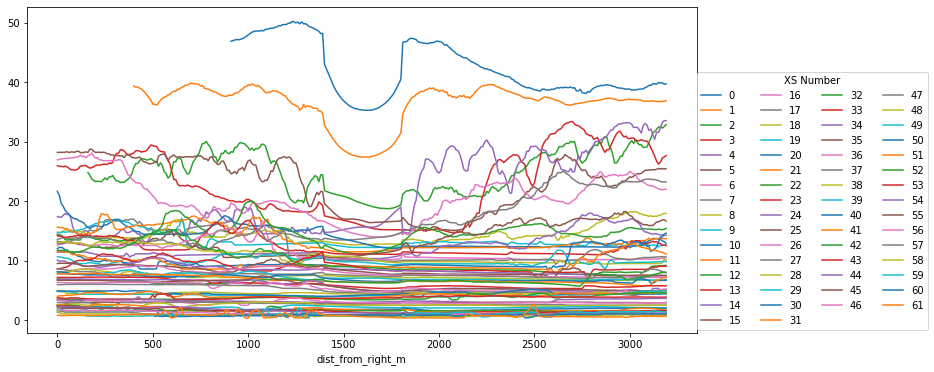

In [26]:
fig,ax = plt.subplots(figsize=(12,6))

xs_levee_smooth.plot(ax=ax)
ax.legend(ncol=4, loc=(1,0.01), title='XS Number')


In [89]:
# import pprint
# import rasterio
# from rasterio import features

### Plan to create setback XS
1. Load DEM and sample XS for frequent intervals and review
2. Try removing the levee from just the XS 
3. Add new 'levee wall' at desired setback distance
4. If code isn't fluid enough to alter XS then look at altering DEM, but altering XS should be easier (1D vs 2D)

In [328]:
# ma_dem_10m = np.ma.masked_where(dem_10m==dem_10m.min(), dem_10m)
# plt.imshow(ma_dem_10m[0,:,:])

In [122]:
# image = features.rasterize(
#             ((g, v) for g, v in zip(cr.geometry.values, -99.99*np.ones(len(cr)))),
#             out_shape=rio10_utm.shape, all_touched=True, transform=rio10_utm.transform)

## Raster elevation calculations
1. Keep in raster format and making changes as you sample
2. Convert to array and work from it with a grid reference file

In [53]:
# from shapely.geometry import Polygon
# vertices = list(m_domain.geometry.values[0].exterior.coords)[0:4]
# geoms = Polygon(vertices)

# rio10_utm.plot()
# t0 = time.time()
# rio10_utm.crop(vertices, invert=False)
# crop_time = time.time() - t0
# rio10_utm.plot()


In [4]:
# dem data for cropping above land surface
# dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')

In [56]:
# grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

In [55]:
# buf_sfr = grid_sfr.copy()
# setbacks = np.arange(0, 3400,200)
# str_setbacks = np.zeros((len(setbacks),nrow,ncol))
# # grid_sfr.plot()
# for n in np.arange(0,len(setbacks)):
#     buf_sfr.geometry = grid_sfr.buffer(setbacks[n])
#     grid_sfr_buf = gpd.sjoin(grid_p,buf_sfr, how='right', lsuffix = 'grid', rsuffix = 'sfr',op='within')
#     grid_sfr_buf = grid_sfr_buf.drop_duplicates('node_x')
#     str_setbacks[n, grid_sfr_buf.row_x.values-1,grid_sfr_buf.column_x.values-1] = 1


# Mannings equation
The assumption of levee setback is that as the setback distance increases so does the wetted xs perimeter which increases the hydraulic radius (there is more roughness impacting the water) so the velocity will be lower. This analysis is independent of varying geology, and river reach under the assumption that any recontoured reach would undergo restoration resulting in similar reach rougnesses of the floodplain (small bushes, trees). And it will assume the existing average bed slope of the lower Cosumnes river applies.  
This analysis could be done by running a HEC-RAS model at all of these different setback distances, but here the goal is to determine the trend and general distance at which diminishing returns occur.  The analysis will be completed first for a typical winter flood event of 2,000 cfs which is near floodplain connectivity (need to approximate area and velocity of channel as starting point or else will need to cycle through several areas/wetted perimeters - better to just use multiple areas that connect to multiple possibles flood sizes )  
The width will range from 0 to 3200 meters in both direction but I coud have depth be dependent on the actual elevations

$ Q = VA = (\frac{1.00}{n}) A  {R}^{2/3} \sqrt{S} $  
$ R = \frac{A}{Wp}$  
hydraulic radius r is XS area divided by wetted perimeter  
[Manning's eqn reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Manning_s_Equation.htm)  
Avg manning's n for in channel is 0.048  - clean, winding, some pools and shoals, but some weeds and stones, lower stages, more ineffective, slopes and sections
Floodplains have much broader range, due to variability in vegetation type: tall grass is 0.035 but dense willows is 0.15  
[Manning's n reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm)  

Slope for Cosumnes could be considered the 0.0006 which is the mean for all reaches

In [86]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` 

In [27]:
# Q_cfs = 2000 # discharge is 2000 cfs, roughly 2-3 yr event
# Q_cfs = 10000 # discharge is 10,000 cfs, roughly 10-20 yr event
Q_cfs = 20000 # discharge is 20,000 cfs, 

Q_cms = Q_cfs*(0.3048**3)

# will need to iterative solve for Area
# nwt technique with derivative, solving for depth
# area is the sum of area between depth and ground surface

In [28]:
def mannings(x, Q, xs_elevs):
    d = x
    n = 0.048
    S = 0.001  
    wse = xs_elevs.min()+d
    xs_wet = wse - xs_elevs
    xs_wet[xs_wet < 0] = 0
    # multiply by 10m to get area and sum for area
    A = xs_wet.sum() * 10
    # calculate wetted perimeter
    xy = xs_elevs[wse - xs_elevs > 0]
    Wp = np.sum(np.sqrt(np.diff(xy.values)**2 + np.diff(xy.index.values)**2))
    Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
    f0 = abs(Q_calc - Q)
    return(f0)

In [29]:
from scipy.optimize import fsolve, least_squares, minimize, minimize_scalar
# fsolve(mannings, [2], args = (Q_cms, xs_elevs), xtol=1E-5)
# least_squares(mannings, [2], args = (Q_cms, xs_elevs), bounds = (0, 10), ftol=1E-5)
# minimize(mannings, [1.], args = (Q_cms, xs_elevs), bounds=[(0,10)], tol=1E-5)

# # res = minimize_scalar(mannings,  args = (Q_cms, xs_elevs), bounds=(0,10), method='bounded')
# res

NameError: name 'xs_elevs' is not defined

In [30]:
depths = np.zeros(xs_levee_smooth.shape[1])
for nseg in np.arange(0,xs_levee_smooth.shape[1]):
    res = minimize_scalar(mannings,  args = (Q_cms, xs_levee_smooth.iloc[:,nseg]), bounds=(0,10), method='bounded')
    depths[nseg] = res.x

In [537]:
# depths20k = np.copy(depths)
# depths2k = np.copy(depths)

In [570]:
depths20k - depths
np.median((depths20k - depths)/((depths20k+ depths)/2)*100)
# np.median(abs((depths2k - depths)/((depths20k+ depths)/2)*100))

74.26932161214337

 0.00024 is the slope which matches the mean slope of the streambed


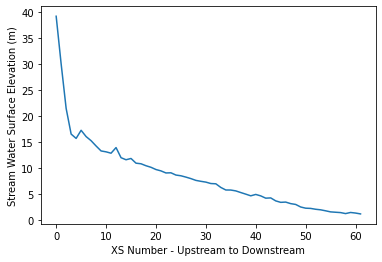

In [52]:
plt.plot(xs_levee_smooth.min()+depths)
plt.xlabel('XS Number - Upstream to Downstream')
plt.ylabel('Stream Water Surface Elevation (m)')

print(' %.5F is the slope' % (15/(62*1000)), 'which matches the mean slope of the streambed')

plt.savefig('water surface elevation profile (m) at' + str(Q_cfs)+'cfs.png')

Text(0, 0.5, 'Stream Depth (m)')

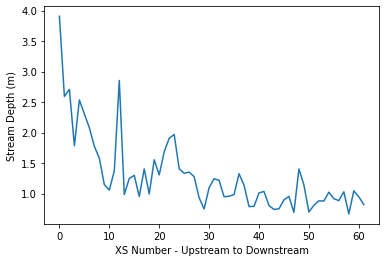

In [31]:
plt.plot(depths)
plt.xlabel('XS Number - Upstream to Downstream')
plt.ylabel('Stream Depth (m)')
# plt.savefig('Depth profile (m) at' + str(Q_cfs)+'cfs.png')

### Interpolate WSE over model grid

In [210]:
wse_all = pd.DataFrame(xs_levee_smooth.min()+depths, columns=['wse_m'])
wse_interp = xs_all.join(wse_all, on='xs_num')
# wse_interp.geometry = wse_interp.buffer(10)

In [211]:
wse_grid = gpd.sjoin(wse_interp, grid_p, how='left', op='within')
# wse_grid = gpd.sjoin(grid_p, wse_interp,  how='left', op='overlaps')

print(wse_grid.node.isna().sum(), 'nodes are NAs when joining grid, most likely due to values near top of domain')
wse_grid = wse_grid.dropna(subset=['node'])

214 nodes are NAs when joining grid, most likely due to values near top of domain


In [159]:
ncell = nrow*ncol
# Get the xy cell centers for the model grid
# xy = np.append(m.modelgrid.xcellcenters,m.modelgrid.ycellcenters, axis = 0)
out_xy = np.transpose(np.vstack((grid_p.centroid.x.values, grid_p.centroid.y.values)))

# reshape the xy data
# out_xy = np.transpose(np.vstack([np.reshape(xy[0:nrow], ncell),np.reshape(xy[nrow:],ncell)]))


from scipy.interpolate import griddata
in_xy = np.transpose(np.vstack([wse_grid.geometry.x.values, wse_grid.geometry.y.values]))
# Final reshaped array of interpolated ET
final = np.zeros((1,nrow, ncol))
# could loop over all flow water surface elevations later

for i in np.arange(0,1):
    # scipy interpolation based on point locations
#     notna_data = spd.iloc[i].notna().values
    grid = griddata(in_xy, wse_grid.wse_m.values, xi = out_xy, method = 'linear')
    final[i,:,:] = np.reshape(grid, (nrow,ncol))

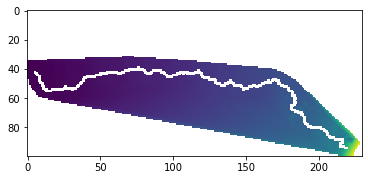

In [160]:
final_riv = np.copy(final[0,:,:])
final_riv[grid_sfr.row.values.astype(int),grid_sfr.column.values.astype(int)] = np.nan
plt.imshow(final_riv)


In [212]:
in_xy[:,0].shape, wse_grid.wse_m.values.shape

((19626,), (19626,))

In [214]:
from scipy.interpolate import interp2d
# f = interp2d(df['x'], df['y'], df['Pa'], kind='linear')
f = interp2d(in_xy[:,0],in_xy[:,1], wse_grid.wse_m.values, kind='linear')

In [215]:
# create 230K by 230K not right
interp_wse = f(out_xy[:,0], out_xy[:,1])

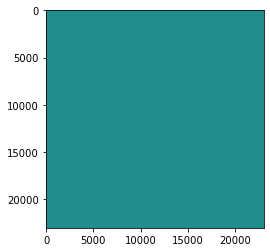

In [221]:
plt.imshow(interp_wse)

<AxesSubplot:>

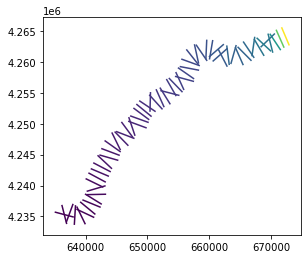

In [55]:
# take each XS and set every point in it as the WSE elevation for that XS
# could spatial join transg to model grid then use those polygons for interpolation?
# then linearly interpolate between XS in the raster
transg['wse_m'] = xs_levee_smooth.min()+depths
transg.plot('wse_m')

# scipy grid data can take points and convert them into a raster

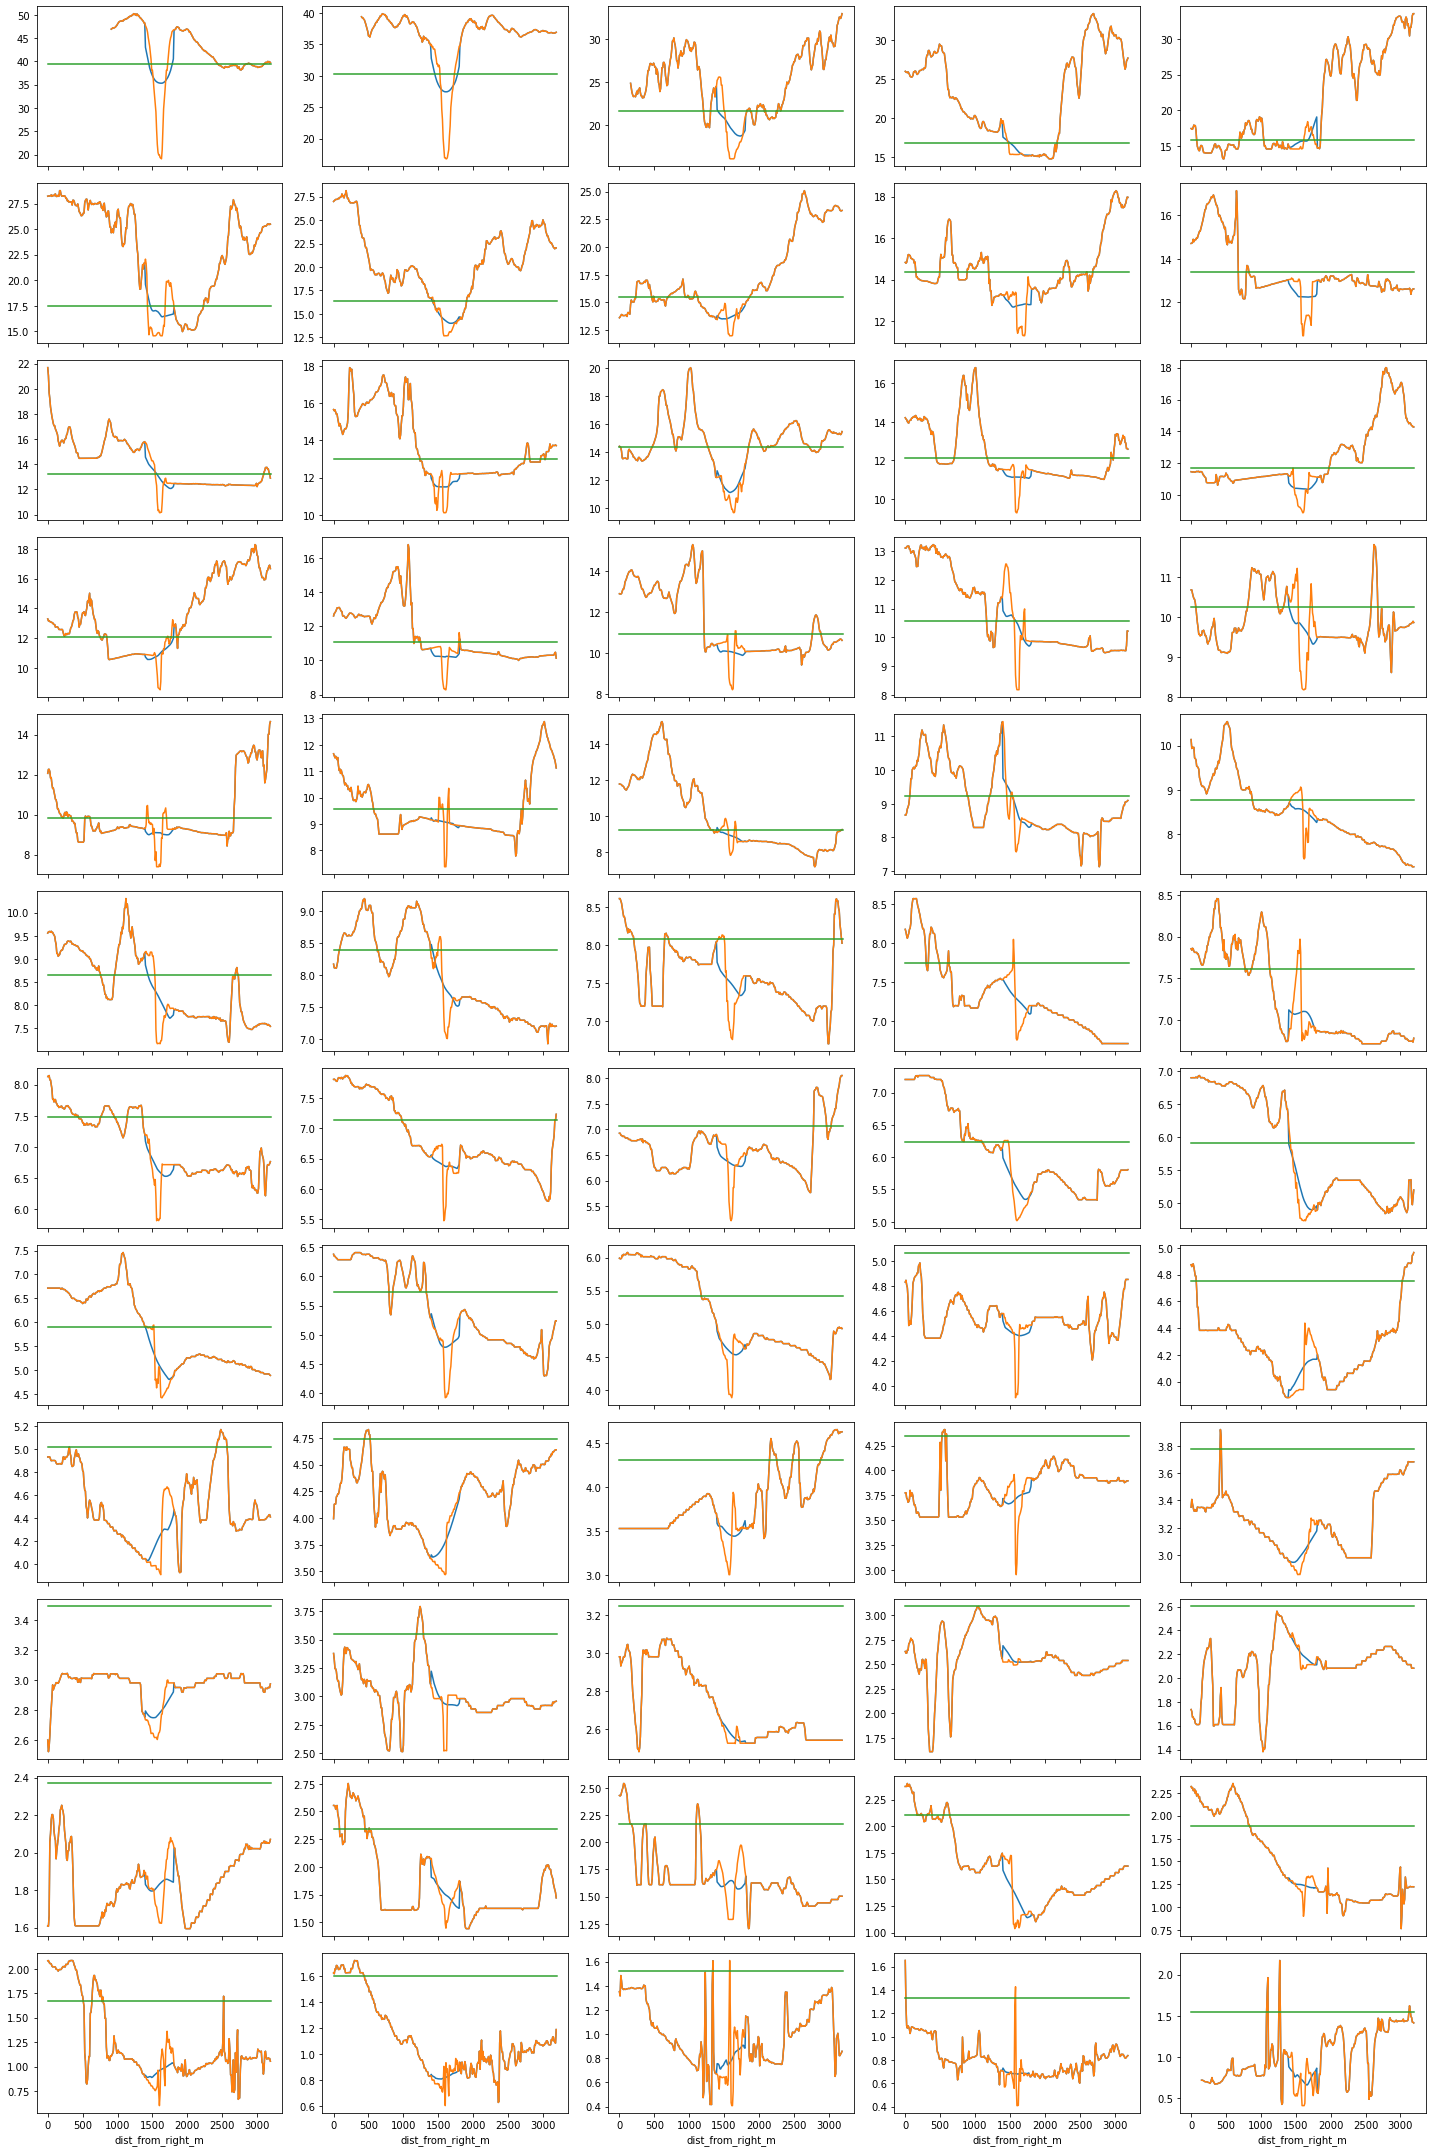

In [521]:
nx,ny = 12,5
fig,ax = plt.subplots(nx,ny, figsize=(20,30),sharex=True, sharey=True)
n=0
for i in np.arange(0,nx):
    for j in np.arange(0,ny):
        xs_levee_smooth.iloc[:,n].plot(ax=ax[i,j])
        xs_all_df.iloc[:,n].plot(ax=ax[i,j])
        ws = xs_levee_smooth.iloc[:,n].min() +depths[n]
        ax[i,j].plot([0,3200],[ws,ws])
        n+=1
fig.tight_layout()
plt.savefig('upstream to downstream XS original then smoothed then flood depth for' +str(Q_cfs)+ 'cfs.png')

Text(0.5, 0, 'Setback distance (m)')

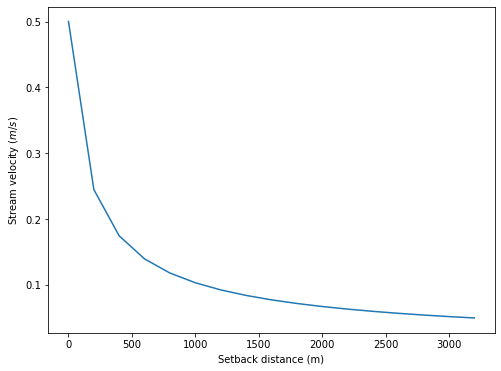

In [40]:
# n = 0.1
# s = grid_sfr.slope.mean()
# fig,ax = plt.subplots(figsize=(8,6))
# flow = (1/n)*(hr**(2/3))*np.sqrt(s)
# plt.plot(setbacks,flow)
# plt.ylabel('Stream velocity ($m/s$)')
# plt.xlabel('Setback distance (m)')

# plt.savefig('stream velocity by setback.png',dpi=600)